In [2]:
import os
import openai
import random
import urllib.request
import ipywidgets as widgets
import matplotlib.pyplot as plt
import Augmentor as aug
import shutil
from PIL import Image, ImageDraw

# Load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")

# Constants

In [3]:
BACKGROUND_PATH = "backgrounds/"
IMAGE_PATH = "dataset/train/images"
LABEL_PATH = "dataset/train/labels"
TRAFFIC_SIGN_PATH = "traffic_signs_only"
TEMP_PATH = "temp"

# Generate Images

In [4]:
# create a slider for the number of images to generate
slider = widgets.IntSlider(min=0, max=100, step=1, value=10, description='Number of images to generate:')
display(slider)

IntSlider(value=10, description='Number of images to generate:')

Generated background image with road type 'A photograph of a highway with traffic and pedestrians from drivers perspective.':


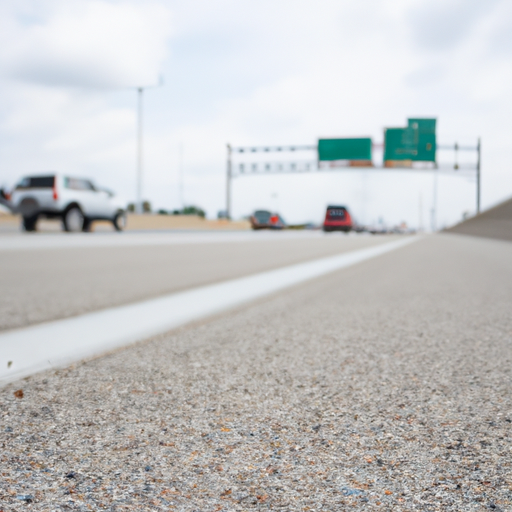

Initialised with 1 image(s) found.
Output directory set to temp\output.

Processing <PIL.Image.Image image mode=RGBA size=33x33 at 0x199FFB4A548>: 100%|██████████| 1/1 [00:00<00:00, 166.63 Samples/s]

Generated image with traffic signs:


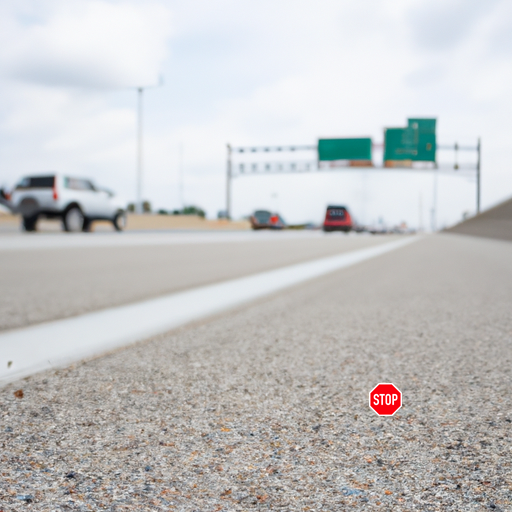

Generated image with bounding boxes:


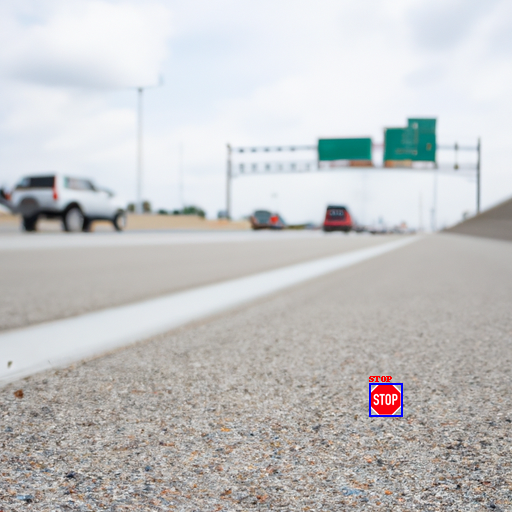

In [5]:
# create a dictionary to save the positions of the traffic sign images on the background image
traffic_sign_positions = {}
# create for loop for the number of images to generate
for i in range(slider.value):
    # a list of different types of roads in different environments 
    road_types = ["highway", "highway with traffic", "highway with traffic and pedestrians", "highway with traffic and pedestrians and construction", "highway with traffic and pedestrians and construction and road works", "autobahn", "street", "street with traffic", "street with pedestrians"]
    # use DALL-E to generate a background image environment that usually contain traffic signs
    random_road_type = f"A photograph of a {road_types[random.randint(0, len(road_types)-1)]} from drivers perspective."
    response = openai.Image.create(
        prompt=random_road_type,
        n=1,
        size="512x512"
    )
    image_url = response["data"][0]["url"]
    # get amount of images in background directory
    amount_background_images = len(os.listdir(BACKGROUND_PATH))
    # download the image to and save it to the background directory
    urllib.request.urlretrieve(image_url, f"{BACKGROUND_PATH}/background_{amount_background_images}.png")
    # open the image with PIL
    pil_image = Image.open(f"{BACKGROUND_PATH}/background_{amount_background_images}.png")
    # show pil image in notebook
    print(f"Generated background image with road type '{random_road_type}':")
    display(pil_image)
    # get 1-4 random images from the traffic sings only directory
    random_images = random.sample(os.listdir(TRAFFIC_SIGN_PATH), random.randint(1, 4))
    # create temporary directory for the traffic sign images
    if not os.path.exists(TEMP_PATH):
        os.mkdir(TEMP_PATH)

    # copy images to temp directory
    for image in random_images:
        shutil.copy(f"{TRAFFIC_SIGN_PATH}/{image}", TEMP_PATH)

    # define a random size for the traffic sign images
    size = random.randint(10,60)
    # apply augmentation to the image
    p = aug.Pipeline(TEMP_PATH)
    p.resize(probability=1.0, width=size, height=size)
    p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
    p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)
    p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)
    p.random_color(probability=0.5, min_factor=0.5, max_factor=1.5)
    p.sample(len(random_images))
        
    # for each image in the temporary directory
    for image in os.listdir(f"{TEMP_PATH}/output"):
        # open the image with PIL
        image = Image.open(f"{TEMP_PATH}/output/{image}")
        # define a random position for the traffic sign image on the background image to be placed    
        random_position = (random.randint(10, 502), random.randint(10, 502))
        # paste the traffic sign image on the background image
        pil_image.paste(image, random_position, mask=image)
        # get image name
        image_name = image.filename
        # save the position of the traffic sign image
        traffic_sign_positions[image_name] = random_position
    
    # get all strings in list to one string without png extension
    # remove .png extension for each string in list
    random_images = [image.split(".")[0] for image in random_images]
    image_save_name = "_".join(random_images)    
    # save the image to the dataset directory
    pil_image.save(f"{IMAGE_PATH}/{image_save_name}.png")
    # display the image
    print("Generated image with traffic signs:")
    display(pil_image)

    for image_name, position in traffic_sign_positions.items():
        with Image.open(f"{image_name}") as image:
            width, height = image.size
            # get the width and height of the image
            width, height = image.size
            # draw boxes around the traffic sign images
            draw = ImageDraw.Draw(pil_image)
            # draw a rectangle around the traffic sign image
            draw.rectangle([position[0], position[1], position[0] + width, position[1] + height], outline="blue", width=2)
            # draw the class name above the traffic sign image
            draw.text((position[0], position[1] - 10), image_name.split("_")[2].split(".")[0], fill="red")
    # show the image with the boxes
    print("Generated image with bounding boxes:")
    display(pil_image)
    # remove temporary directory
    shutil.rmtree(TEMP_PATH)
    
    # save the bounding boxes to the labels directory
    # with open(f"{LABEL_PATH}/{image_save_name}.txt", "w") as f:
    #     for image_name, position in traffic_sign_positions.items():
    #         # get the width and height of the image
    #         with Image.open(f"{image_name}") as image:
    #             width, height = image.size
    #             # get the class name of the traffic sign image
    #             class_name = image_name.split("_")[2].split(".")[0]
    #             # save the bounding box to the labels directory
    #             f.write(f"{class_name} {position[0]} {position[1]} {width} {height}

